### Windfarms

Here are some examples of windfarms. The name of the files contain the ID of the windfarm. The ERA5 data was selected based on the location in this xls table

In [1]:
import pandas as pd
df = pd.read_excel("https://www.thewindpower.net/data/samples/Sample_World_Windfarms.xls", sheet_name="Windfarms", skiprows=[1])
df.pop("2nd name")
df.head()  # remove .head() to see the full table

,ID,Continent,ISO code,Country,State code,Area,City,Name,Latitude,Longitude,...,Number of turbines,Total power,Developer,Operator,Owner,Commissioning date,Status,Decommissioning date,Link,Update
0,27,Oceania,AU,Australia,QLD,Queensland,Ravenshoe,Windy Hill,-17.590006,145.531549,...,20,12000,Stanwell Corp,Stanwell Corp,Ratch Australia Corporation,2000/08,Production,NaN,Link,2022-10-25
1,13,Europe,BE,Belgium,#ND,Brabant wallon (Wallonie),Villers-la-Ville,Marbais,50.537381,4.514866,...,8,16000,Eneco,Electrastar SA,Eneco,2007,Production,NaN,Link,2022-10-20
2,12,Europe,BE,Belgium,#ND,Liège (Wallonie),Villers le Bouillet,Villers le Bouillet,50.580000,5.240000,...,6,9000,EDF renewables/Energie 2030,EDF renewables,EDF Luminus,2005/02,Production,NaN,Link,2022-05-20
3,16,Europe,BE,Belgium,#ND,Namur (Wallonie),Floreffe,Floreffe,50.422861,4.718278,...,1,2350,EDF Luminus,EDF Luminus,EDF Luminus,2010,Production,NaN,Link,2022-05-20
4,11,Europe,BE,Belgium,#ND,Namur (Wallonie),Walcourt,Tarcienne,50.302828,4.504480,...,6,9000,EDF renewables,EDF renewables,EDF Luminus,2005/11,Production,NaN,Link,2022-05-20


In [2]:
import xarray as xr
import glob
import os

basepath = "/shared1/ICS/LOT1/windpower/"
wfid_list = [
    14, 20, 27
]

# get file from ID
def get_file_from_id(wind_farm_id, basepath):
    files = glob.glob(os.path.join(basepath, "ID_{}_*.nc".format(wind_farm_id)))
    assert len(files) == 1 # make sure there is only one file
    return files[0]


# try with one ID
wind_farm_ds_dict = {
    wind_farm_id: xr.open_dataset(get_file_from_id(wind_farm_id, basepath)).ws100 for wind_farm_id in wfid_list
}

wind_farm_ds_dict[14]

<xarray.DataArray 'ws100' (time: 350640)>
[350640 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 ... 2019-12-31T23:00:00
    longitude  float32 ...
    latitude   float32 ...
Attributes:
    long_name:  100 metre wind speed
    units:      m s**-1

Next, give some parameters for the turbine at this location. 

In [3]:
import numpy as np
import power_curves as pc

# power_conversion_function_csv = pc.power_curve_from_csv("https://www.thewindpower.net/data/samples/Sample_Power_curves.xls", "MM82", "Turbine Name")

power_conversion_function_parameters = [
    {"Pnom": 2000, "Drotor": 80},
    {"Pnom": 2000, "Drotor": 85},
    {"Pnom": 3000, "Drotor": 80},
]

training_set_selection = {
    "time": slice("1980-01-01", "2009-12-31"),
}
test_set_selection = {
    "time": slice("2010-01-01", "2019-12-31"),
}

labels = ["Pnom: {Pnom} kW, Drotor: {Drotor} m".format(**kwargs) for kwargs in power_conversion_function_parameters]

power_conversion_functions = [pc.power_curve_from_parameters_2(wind_speed_resolution=0.5, **kwargs) for kwargs in power_conversion_function_parameters]
power_conversion_functions_old = [pc.power_curve_from_parameters(wind_speed_resolution=0.5, **kwargs) for kwargs in power_conversion_function_parameters]

power_da_list_collection_training = {
    wind_farm_id: [power_conversion_function(da.sel(**training_set_selection)) for power_conversion_function in power_conversion_functions] 
    for wind_farm_id, da in wind_farm_ds_dict.items()
}
power_da_list_collection_old_training = {
    wind_farm_id: [power_conversion_function(da.sel(**training_set_selection)) for power_conversion_function in power_conversion_functions_old]
    for wind_farm_id, da in wind_farm_ds_dict.items()
}
power_da_list_collection_test = {
    wind_farm_id: [power_conversion_function(da.sel(**test_set_selection)) for power_conversion_function in power_conversion_functions]
    for wind_farm_id, da in wind_farm_ds_dict.items()
}

# make sure they are the same
for wind_farm_id in wfid_list:
    for power_da, power_da_old in zip(power_da_list_collection_training[wind_farm_id], power_da_list_collection_old_training[wind_farm_id]):
        assert np.allclose(power_da.values, power_da_old.values)

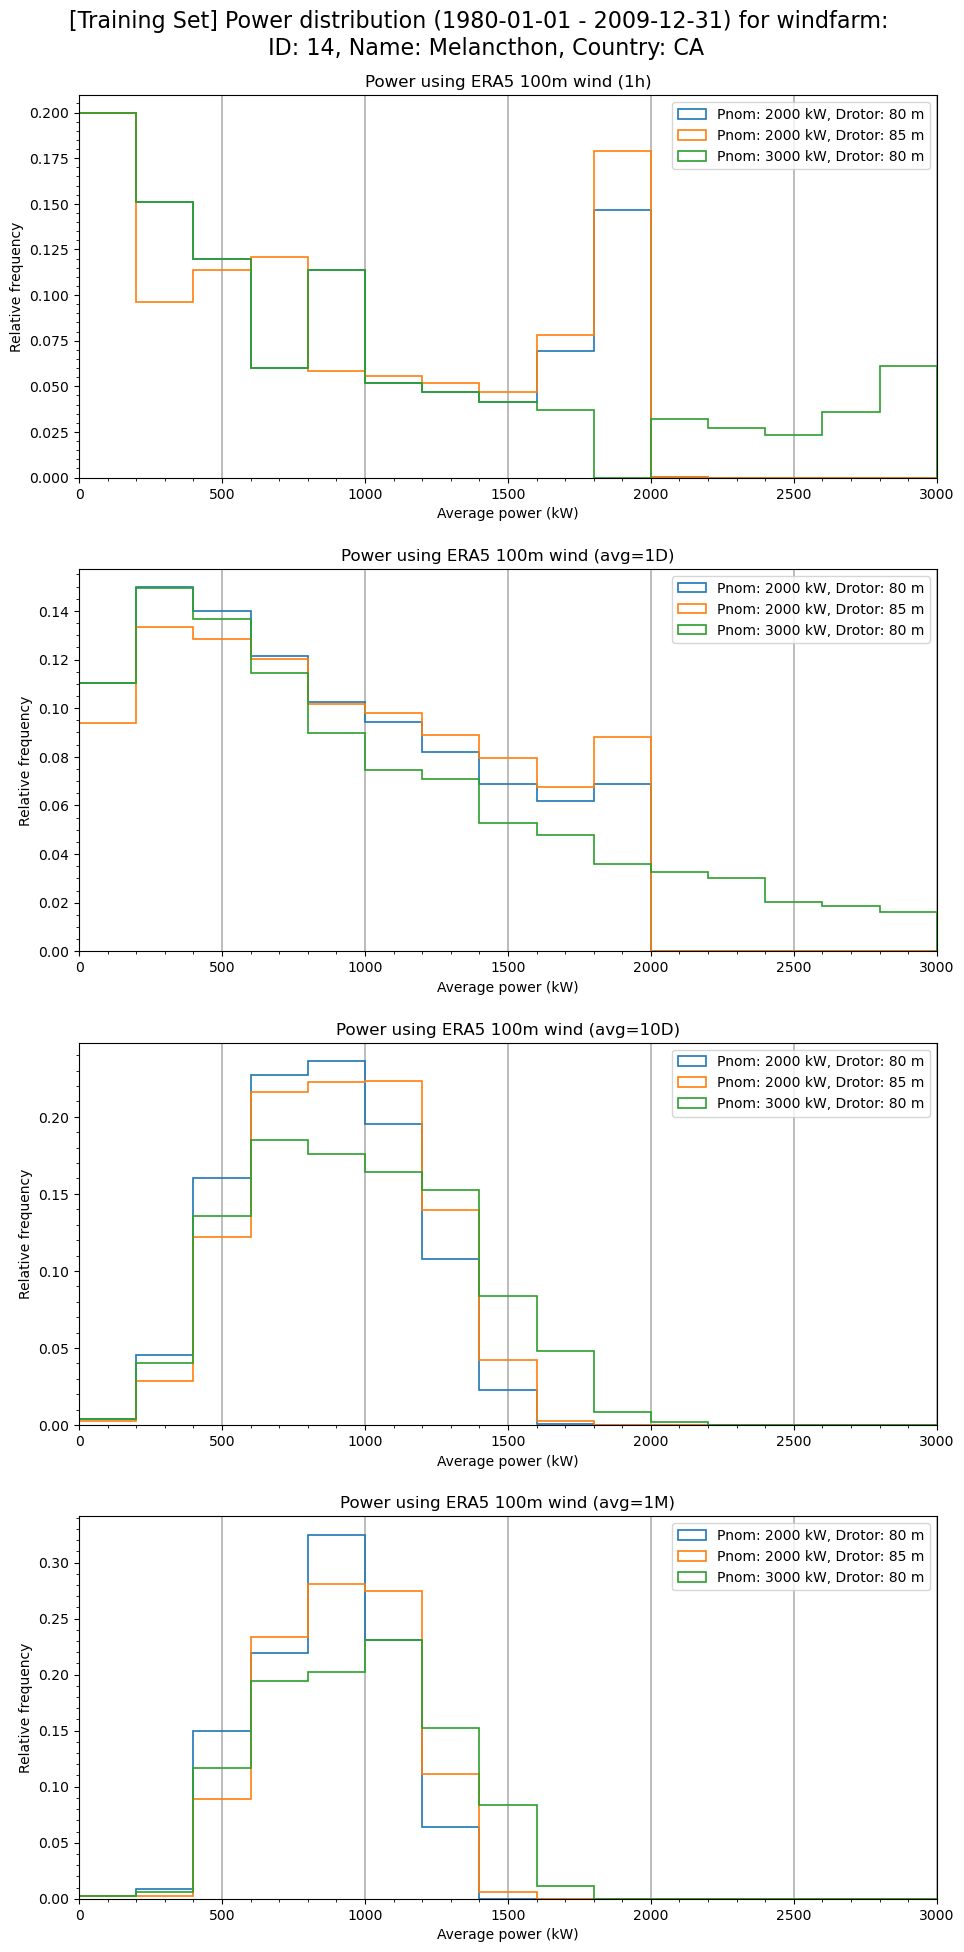

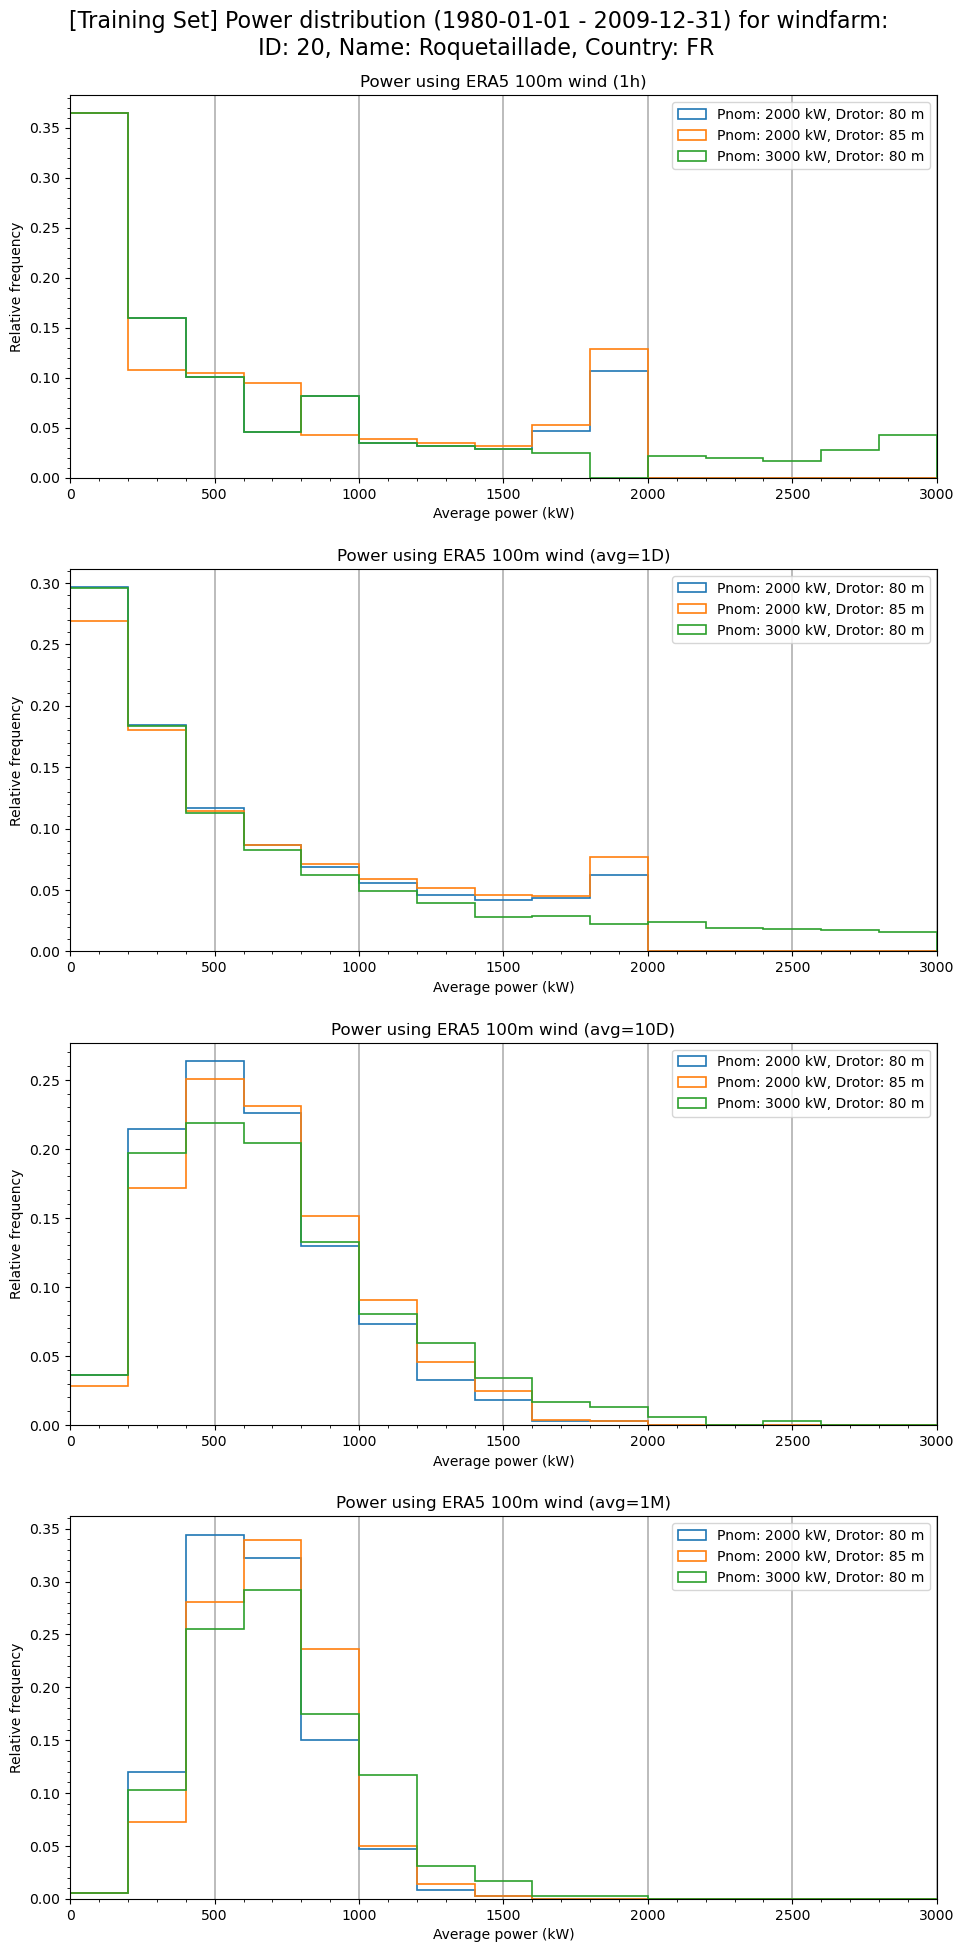

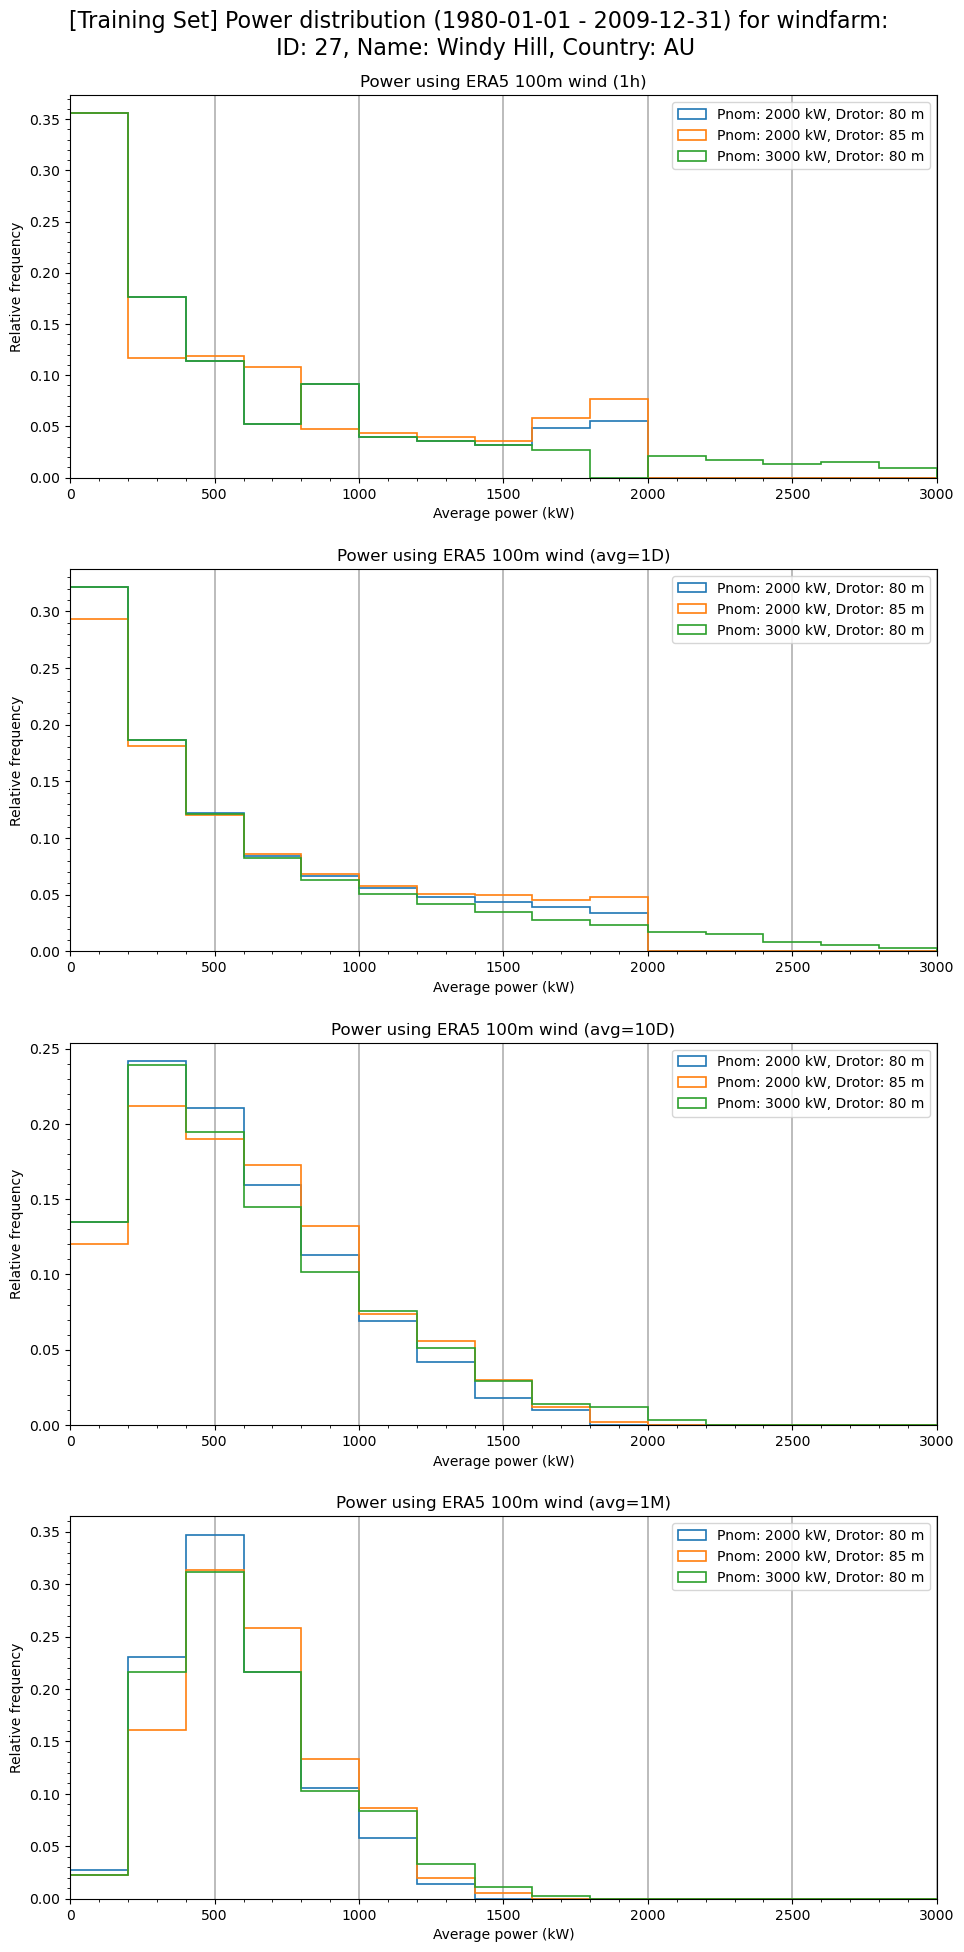

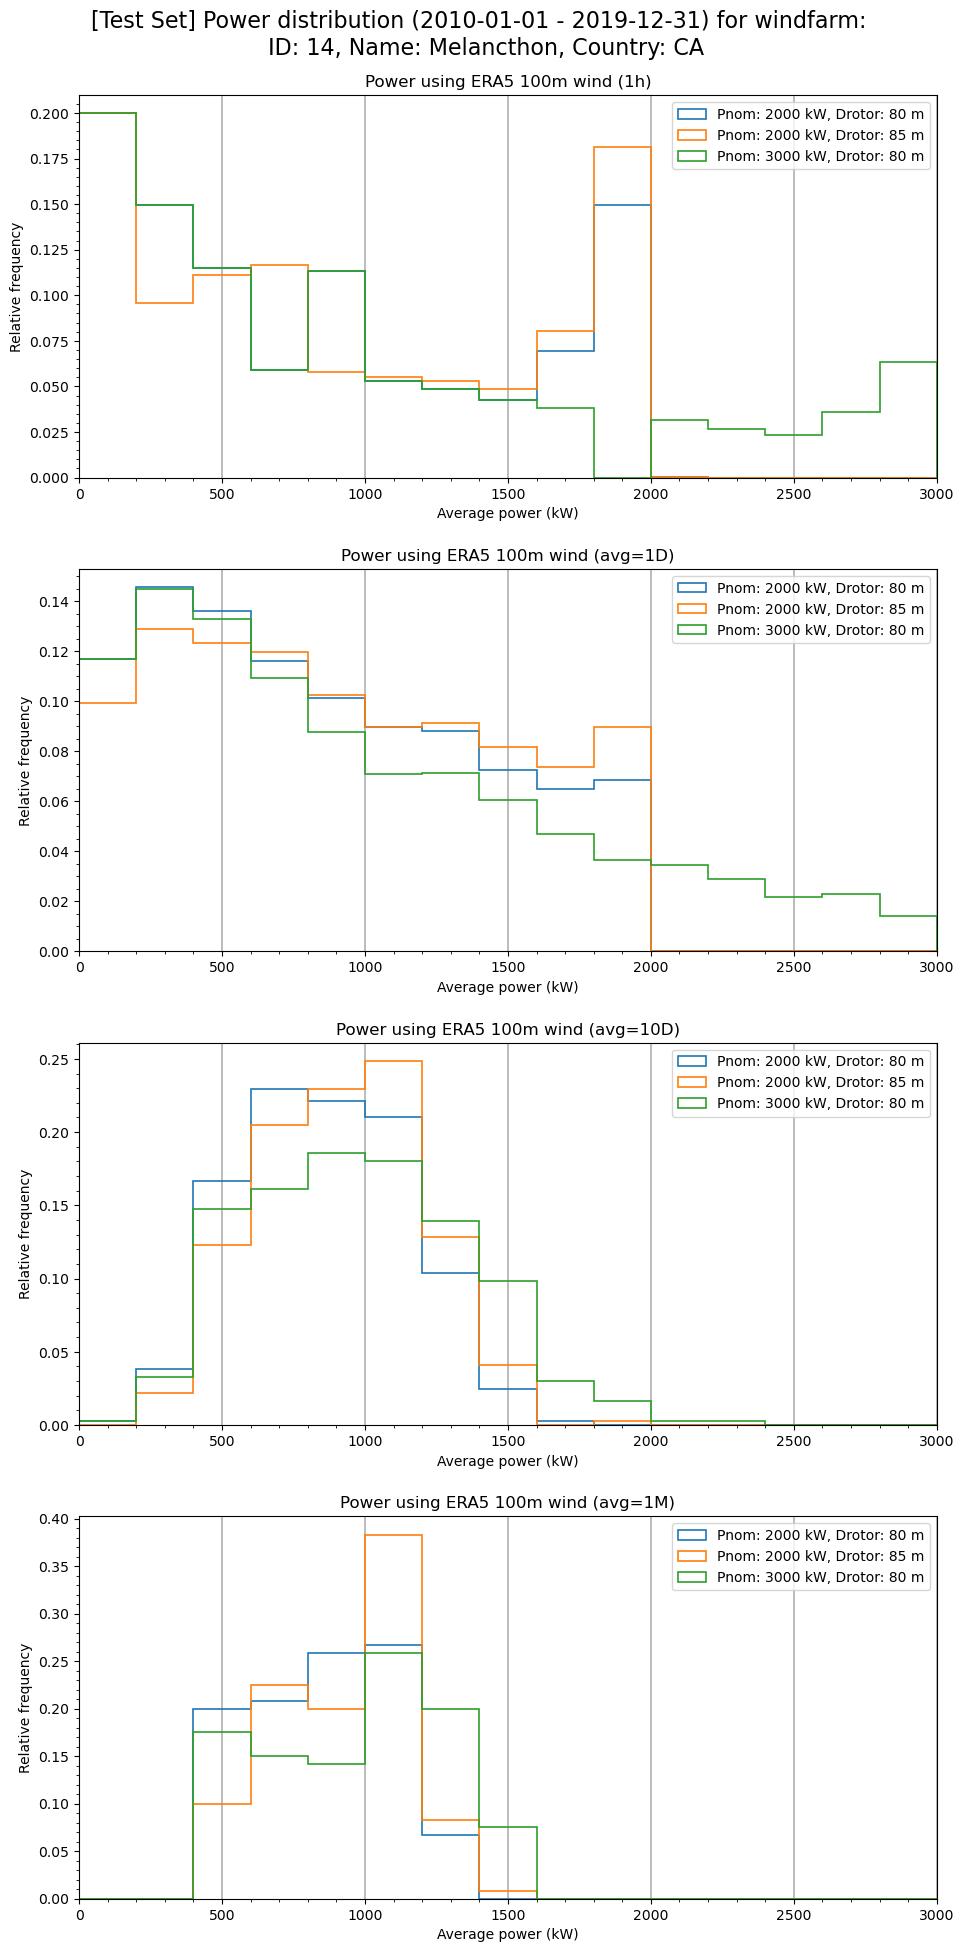

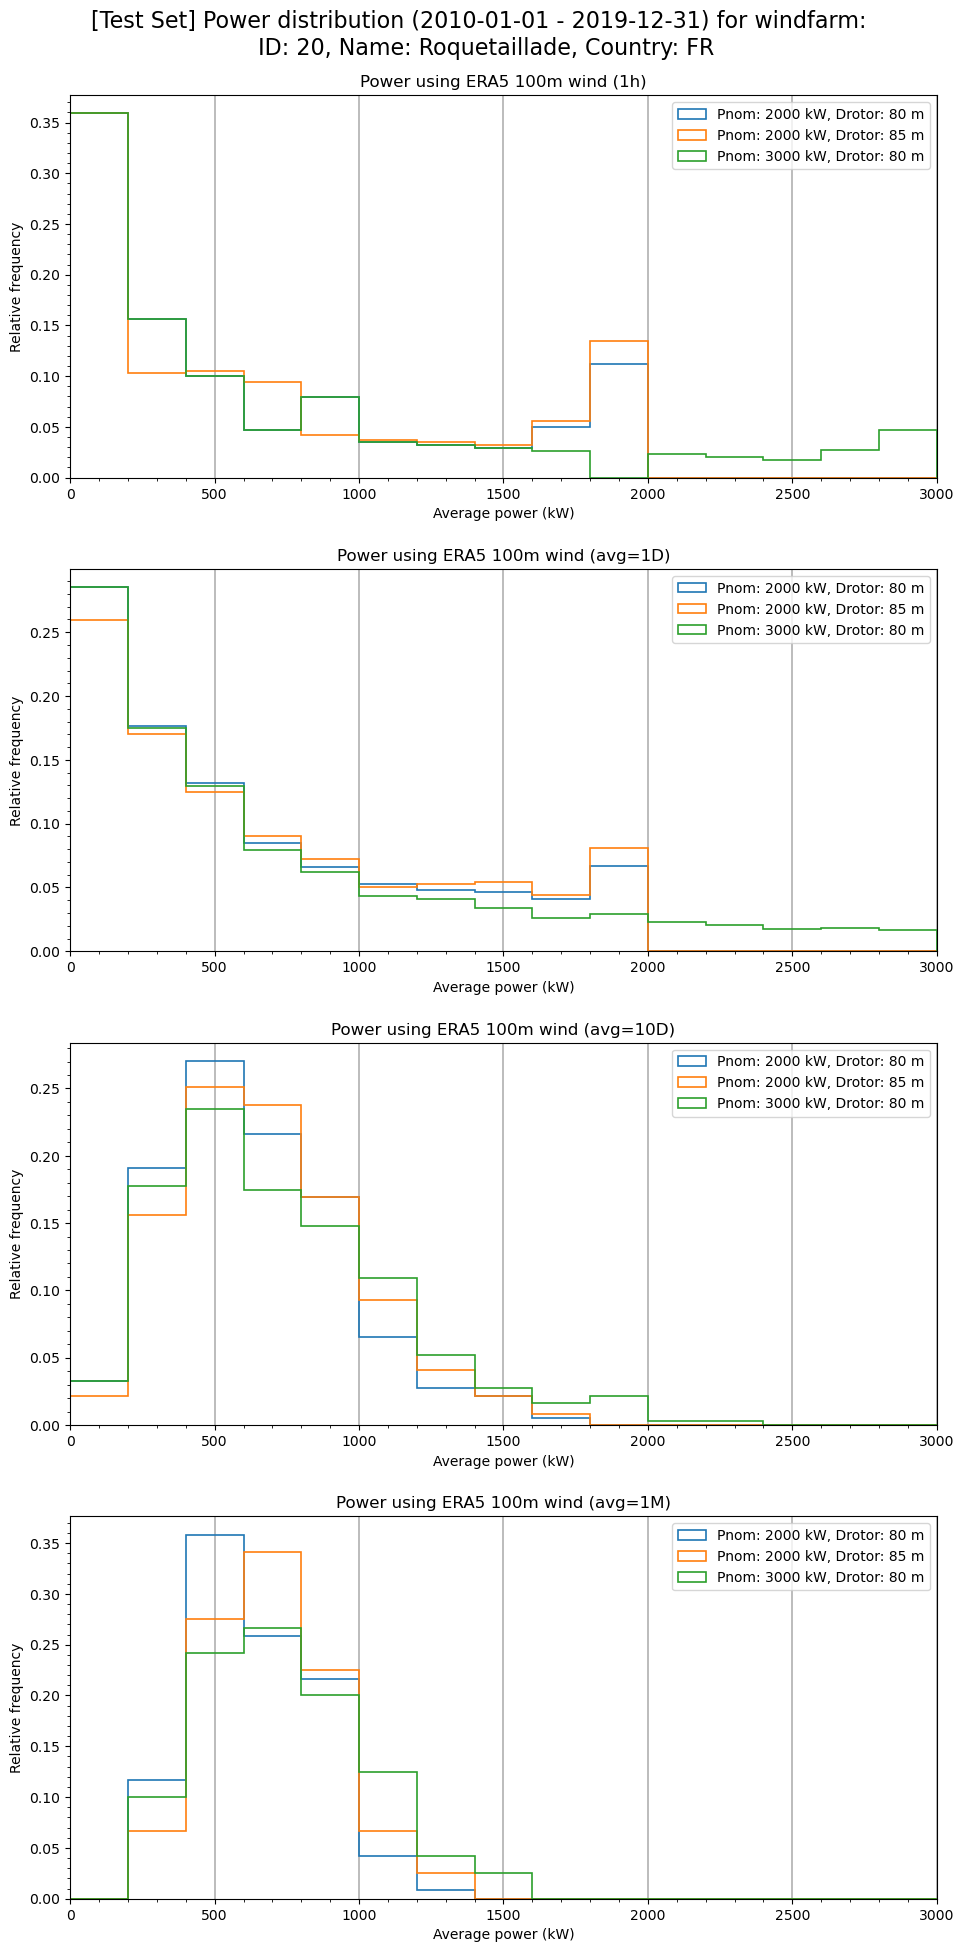

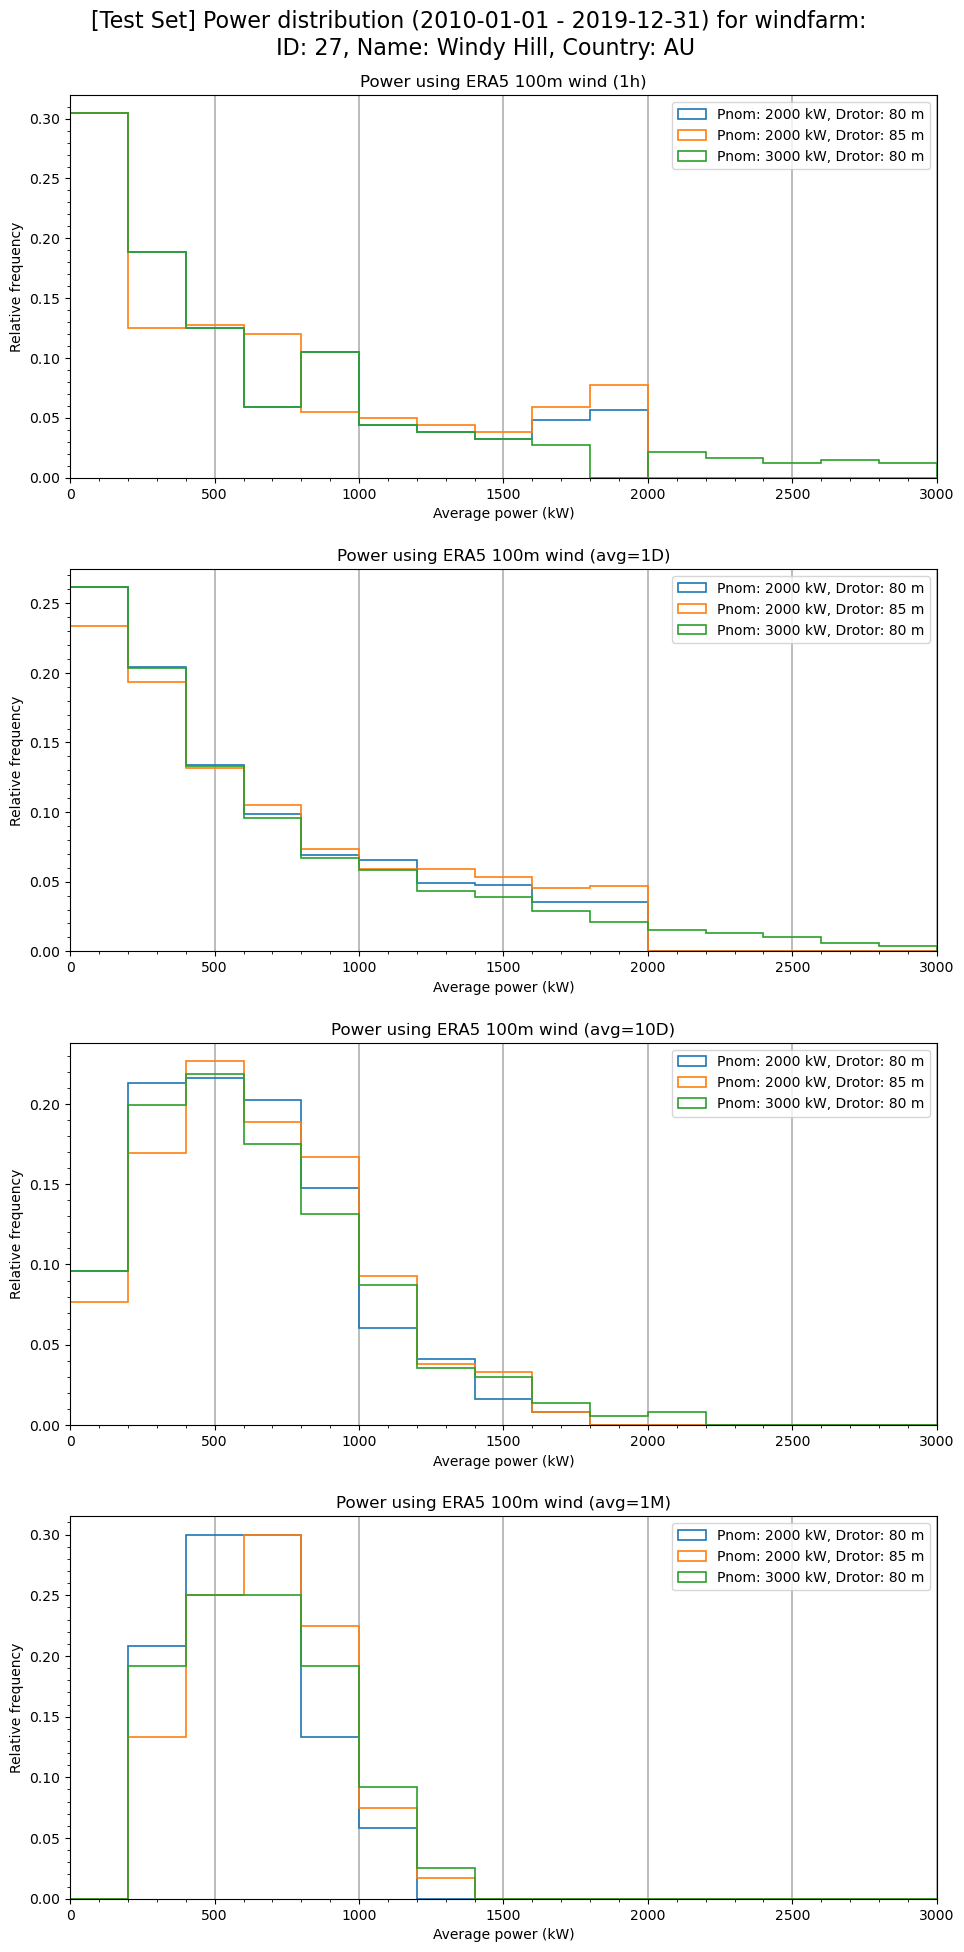

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools

# histograms from power_da_list
def histograms_from_power_da_list(power_da_list, wind_farm_id, labels, training_set: bool):

    bins = np.arange(0, 3200, 200)

    fig, axs = plt.subplots(4, 1, figsize=(10, 20))

    resampling_frequencies = [None, "1D", "10D", "1M"]

    for i, freq in enumerate(resampling_frequencies):

        colors = itertools.cycle(plt.get_cmap("tab10").colors)

        if freq is not None:
            power_da_resampled_list = [power_da.resample(time=freq).mean() for power_da in power_da_list]
        else:
            power_da_resampled_list = power_da_list

        for color, label, power_da_resampled in zip(colors, labels, power_da_resampled_list):
            weights = np.ones_like(power_da_resampled) / len(power_da_resampled)
            n, bins, patches = axs[i].hist(power_da_resampled, bins=bins, weights=weights,
                                        edgecolor=color, linewidth=1.2,
                                        density=False, facecolor="none",
                                        histtype="step", label=label)

        # Adjust the y-axis limits
        axs[i].set_ylim(0, axs[i].get_ylim()[1] / sum(n))

        # Adjust the x-axis limits
        axs[i].set_xlim(0, 3000)

        # Set the title
        if freq is None:
            axs[i].set_title('Power using ERA5 100m wind (1h)')
        else:
            axs[i].set_title(f'Power using ERA5 100m wind (avg={freq})')
        
        axs[i].set_xticks(np.arange(0, 3500, 500))
        axs[i].grid(axis="x", linestyle="-", linewidth=1.2)

        axs[i].set_axisbelow(True)

        # Set x and y labels
        axs[i].set_xlabel('Average power (kW)')
        axs[i].set_ylabel('Relative frequency')

        axs[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
        axs[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())

        axs[i].legend(loc="upper right")

    start_date = power_da_list[0].time[0].dt.strftime("%Y-%m-%d").values
    end_date = power_da_list[0].time[-1].dt.strftime("%Y-%m-%d").values

    train_or_test = "Training Set" if training_set else "Test Set"

    suptitle = "[{}] Power distribution ({} - {}) for windfarm: \n ID: {}, Name: {}, Country: {}".format(
        train_or_test, start_date, end_date,
        wind_farm_id, df[df["ID"] == wind_farm_id]["Name"].values[0], df[df["ID"] == wind_farm_id]["ISO code"].values[0],
    )

    # set the title of the figure
    fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(pad = 2)
    plt.show()

for wind_farm_id, power_da_list in power_da_list_collection_training.items():
    histograms_from_power_da_list(power_da_list, wind_farm_id, labels, training_set=True)

for wind_farm_id, power_da_list in power_da_list_collection_test.items():
    histograms_from_power_da_list(power_da_list, wind_farm_id, labels, training_set=False)

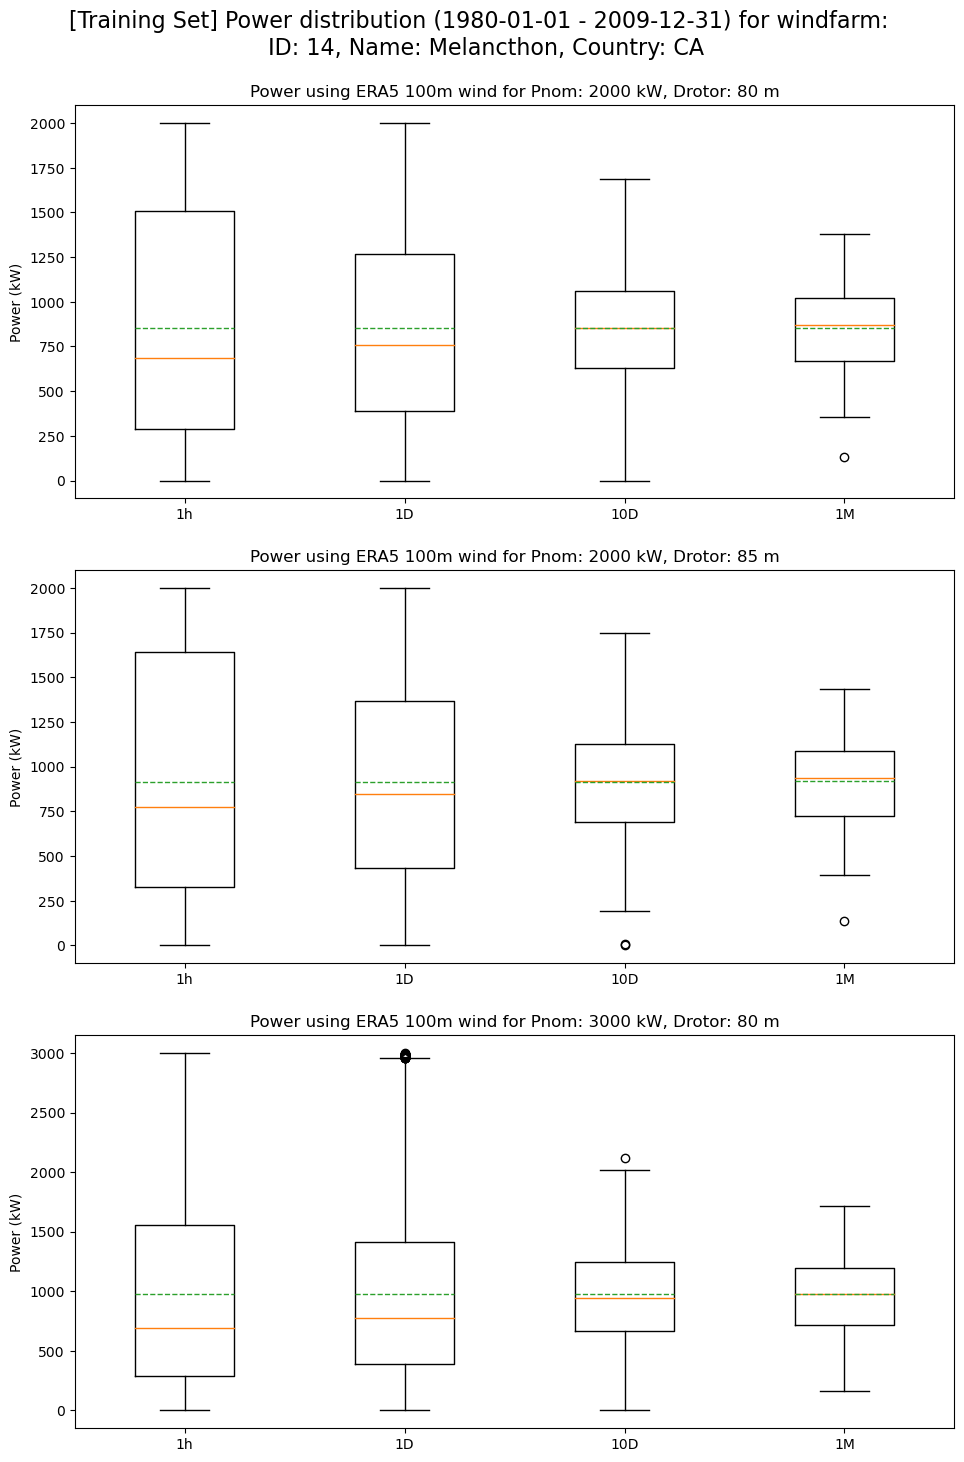

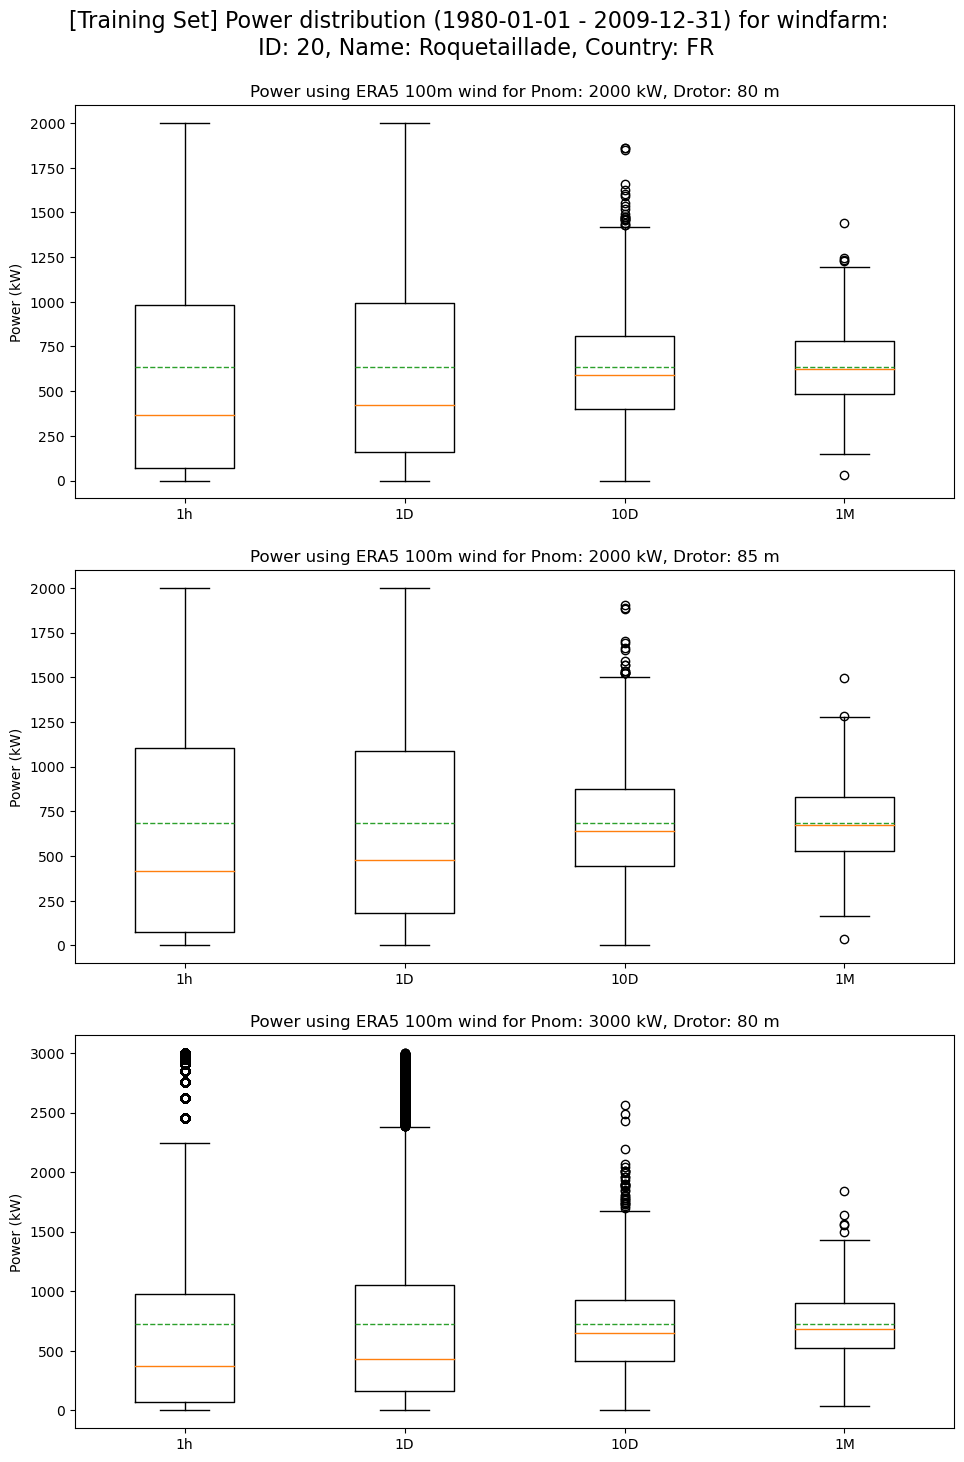

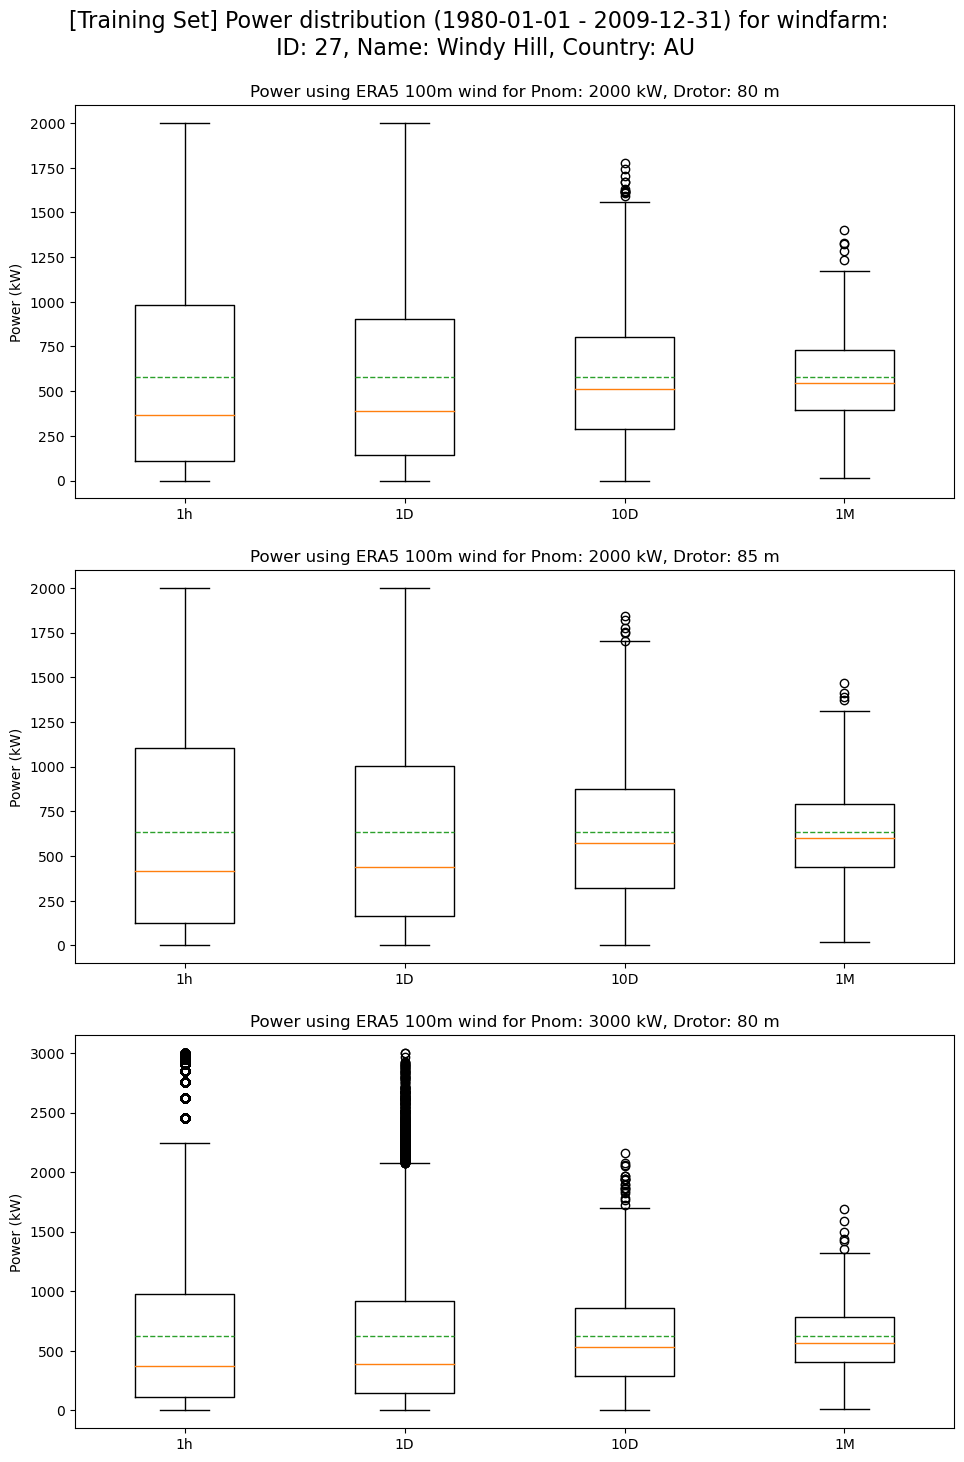

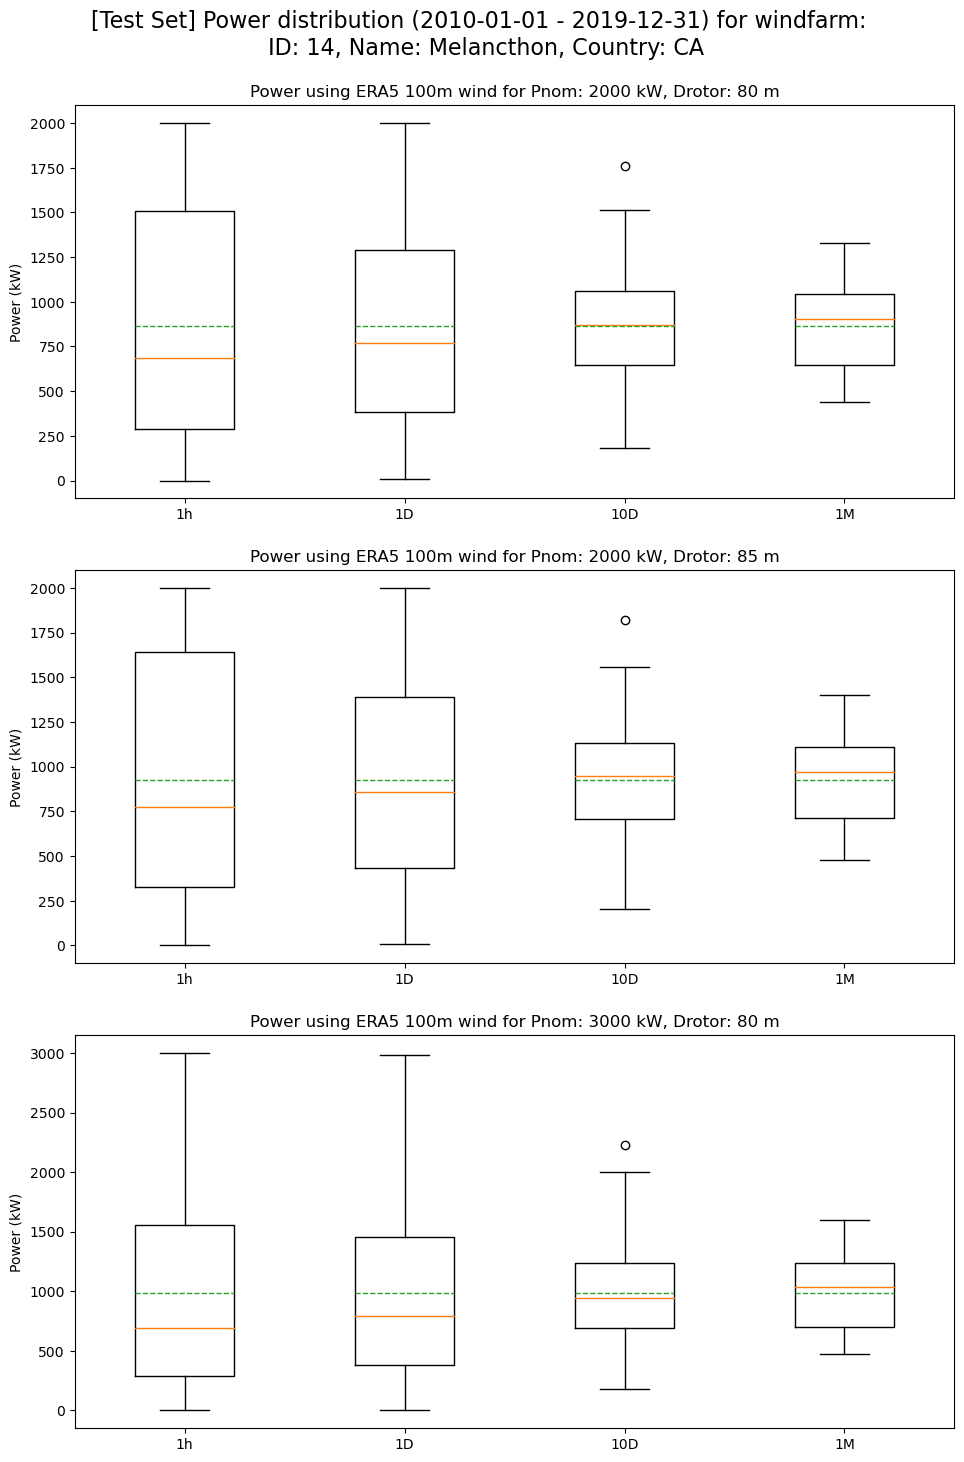

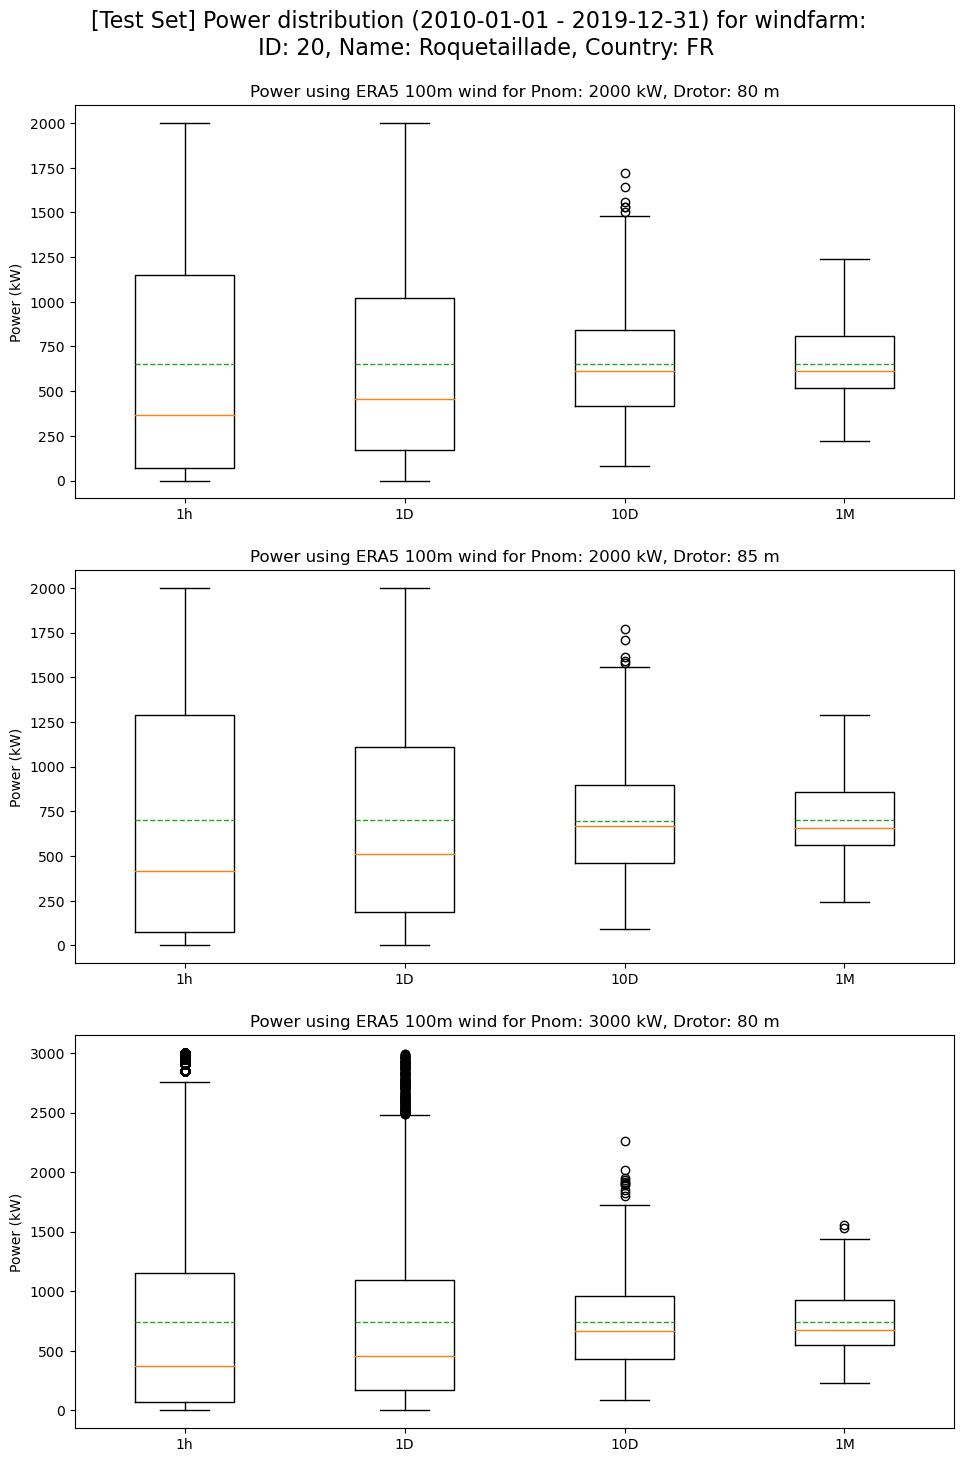

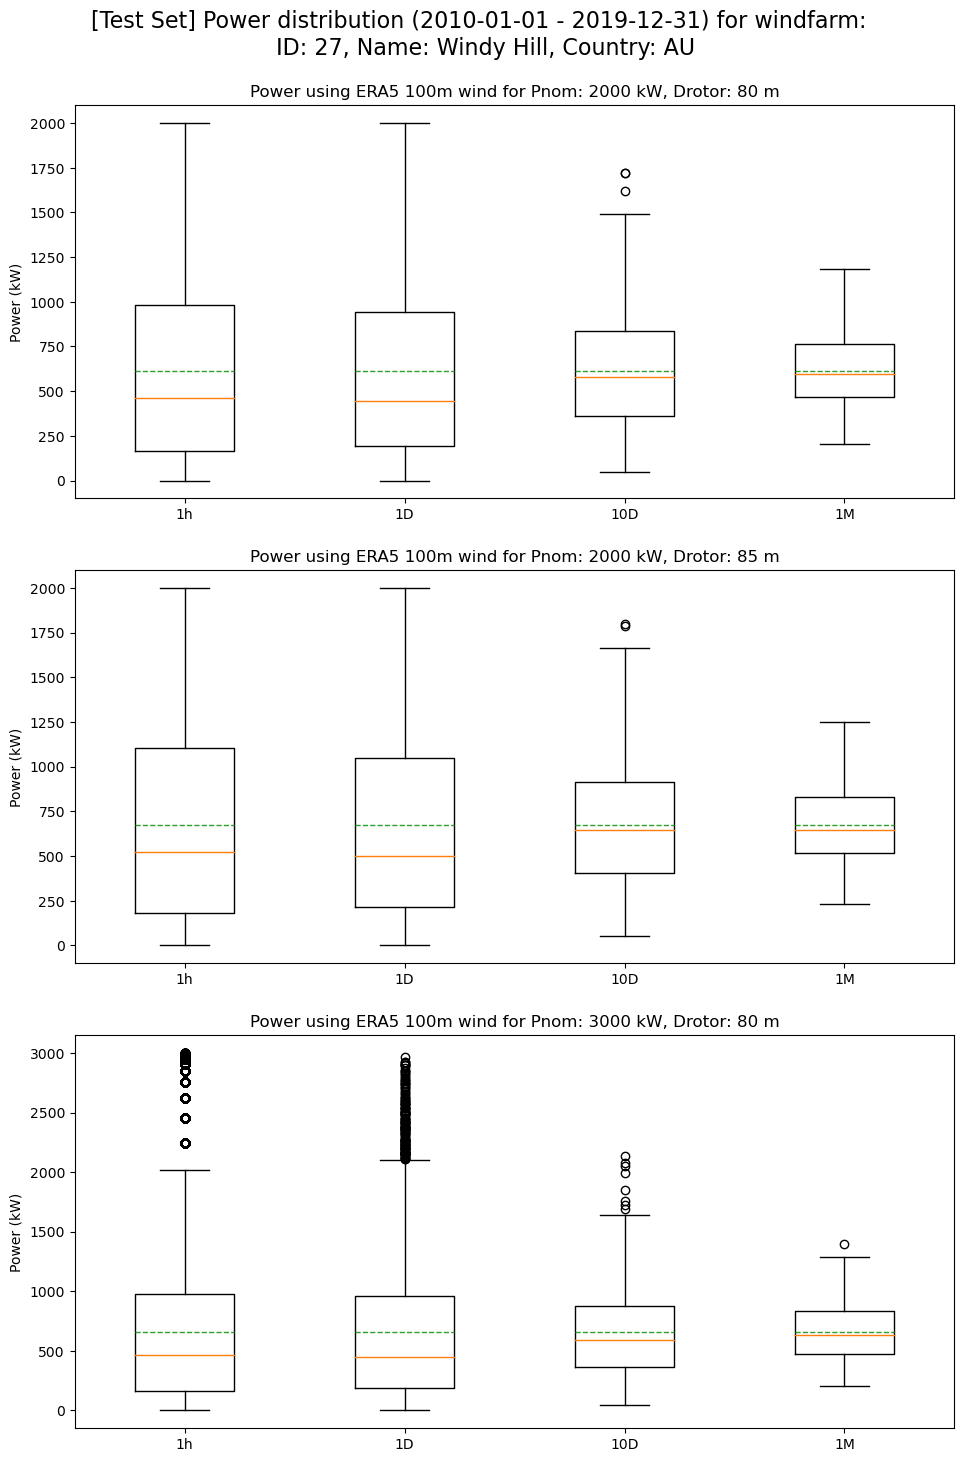

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#boxplots from power_da_list
def boxplots_from_power_da_list(power_da_list, wind_farm_id, labels, training_set: bool):

    resampling_frequencies = [None, "1D", "10D", "1M"]

    fig, axs = plt.subplots(len(power_da_list), 1, figsize=(10, 5*len(power_da_list)))

    for i, (power_da, label) in enumerate(zip(power_da_list, labels)):
        averaged_power_da_list = [power_da] + [power_da.resample(time=freq).mean() for freq in resampling_frequencies[1:]]

        resampling_labels = ["1h", "1D", "10D", "1M"]

        axs[i].boxplot(averaged_power_da_list, labels=resampling_labels, showmeans=True, meanline=True)
        axs[i].set_title(f"Power using ERA5 100m wind for {label}")
        
        # set ylabel
        axs[i].set_ylabel("Power (kW)")

    start_date = power_da_list[0].time[0].dt.strftime("%Y-%m-%d").values
    end_date = power_da_list[0].time[-1].dt.strftime("%Y-%m-%d").values

    training_or_test = "Training Set" if training_set else "Test Set"

    suptitle = "[{}] Power distribution ({} - {}) for windfarm: \n ID: {}, Name: {}, Country: {}".format(
        training_or_test, start_date, end_date,
        wind_farm_id, df[df["ID"] == wind_farm_id]["Name"].values[0], df[df["ID"] == wind_farm_id]["ISO code"].values[0],
    )

    # set the title of the figure
    fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(pad = 2)
    plt.show()

for wind_farm_id, power_da_list in power_da_list_collection_training.items():
    boxplots_from_power_da_list(power_da_list, wind_farm_id, labels, training_set=True)

for wind_farm_id, power_da_list in power_da_list_collection_test.items():
    boxplots_from_power_da_list(power_da_list, wind_farm_id, labels, training_set=False)

In [27]:
quantiles_to_compute = [0, 0.05, 0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9, 0.95, 1]

target_time_resolution = "1M"
intermediate_time_resolution = "1M"

def get_quantiles(power_da, quantiles_to_compute, target_time_resolution):
    averaged_power_da = power_da.resample(time=target_time_resolution).mean()
    return averaged_power_da.quantile(quantiles_to_compute, dim="time")

target_quantiles_dict = {
    wind_farm_id: get_quantiles(power_da_list[0], quantiles_to_compute, target_time_resolution)
    for wind_farm_id, power_da_list in power_da_list_collection_training.items()
}

target_quantiles_dict[14]

<xarray.DataArray 'power' (quantile: 11)>
array([ 132.98923441,  483.82052084,  546.83473252,  666.13410796,
        740.85027123,  869.3885094 ,  971.79182783, 1021.20507507,
       1148.73471615, 1221.65840075, 1379.9856566 ])
Coordinates:
  * quantile  (quantile) float64 0.0 0.05 0.1 0.25 0.33 ... 0.75 0.9 0.95 1.0

In [46]:
import scipy.optimize as opt

from functools import lru_cache

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def count_calls(disable=False):
    def count_calls_decorator(func):
        def wrapper(*args, **kwargs):
            wrapper.calls += 1
            if wrapper.calls % 10 == 0:
                print(f"Call {wrapper.calls} to {func.__name__}")
            return func(*args, **kwargs)
        wrapper.calls = 0
        if disable:
            return func
        return wrapper
    return count_calls_decorator

# @lru_cache(maxsize=10)
@count_calls(disable=True)
def distribution_match(z, *params):
    averaged_wind_intermediate, target_quantiles, kwargs_for_power, target_time_resolution, free_parameters = params
    kwargs = {free_parameter: value for free_parameter, value in zip(free_parameters, z)}
    kwargs_for_power_copy = kwargs_for_power.copy()
    for free_parameter in free_parameters:
        del kwargs_for_power_copy[free_parameter]
    power_curve = pc.power_curve_from_parameters_2(**kwargs, **kwargs_for_power_copy)
    power_da = power_curve(averaged_wind_intermediate).resample(time=target_time_resolution).mean()
    quantiles = power_da.quantile(quantiles_to_compute, dim="time")
    return rmse(quantiles, target_quantiles).values

def optimize_distribution_match(
        averaged_wind_intermediate,
        target_quantiles,
        target_time_resolution,
        bounds: dict,
        Ns: int,
        method="minimize",
        starting_point : dict = None,
        kwargs_for_power=None,
        free_parameters : list[str] = ["Pnom", "Drotor", "Vcutin", "Vcutoff"]):
    
    kwargs_keys = ["Pnom", "Drotor", "Vcutin", "Vcutoff"]

    assert isinstance(bounds, dict), "bounds must be a dictionary"

    assert len(bounds) == len(kwargs_keys)
    
    bounds_list = [bounds[key] for key in kwargs_keys if key in free_parameters]
    bounds_tuple = tuple(bounds_list)

    if method == "minimize":
        if starting_point is None:
            raise ValueError("starting_point must be provided when using method='minimize'")
        
        assert isinstance(starting_point, dict), "starting_point must be a dictionary"
        assert len(starting_point) == len(kwargs_keys)
        starting_point_list = [starting_point[key] for key in kwargs_keys if key in free_parameters]

        params = (averaged_wind_intermediate, target_quantiles, kwargs_for_power, target_time_resolution, free_parameters)
        result = opt.minimize(distribution_match, starting_point_list, args=params, bounds=bounds_tuple, 
                              method="Nelder-Mead", options={"maxiter": 1000, "disp": True})    
        return result.x

    elif method == "brute":
        if bounds is None:
            raise ValueError("bounds must be provided when using method='brute'")
        params = (averaged_wind_intermediate, target_quantiles, kwargs_for_power, target_time_resolution, free_parameters)
        result = opt.brute(distribution_match, ranges=bounds_tuple, args=params, finish=None, Ns=Ns,)
        return result


kwargs_for_power = {
    "Pnom": power_conversion_function_parameters[0]["Pnom"],  # Pnom
    "Drotor": power_conversion_function_parameters[0]["Drotor"],  # Drotor
    "Vcutin": 3,  # Vcutin
    "Vcutoff": 25  # Vcutoff
}


starting_point = {
    "Pnom": power_conversion_function_parameters[0]["Pnom"],  # Pnom
    "Drotor": power_conversion_function_parameters[0]["Drotor"],  # Drotor
    "Vcutin": 3,  # Vcutin
    "Vcutoff": 25  # Vcutoff
}

bounds = {
    "Pnom": (1000, 5000),  # Pnom
    "Drotor": (50, 120),  # Drotor
    "Vcutin": (0, 10),  # Vcutin
    "Vcutoff": (5, 30)  # Vcutoff
}

# free_parameters = ["Pnom", "Drotor", "Vcutin", "Vcutoff"]
# free_parameters = ["Vcutin", "Vcutoff"]
free_parameters = ["Pnom", "Drotor"]

optim_result_dict = {}

for wind_farm_id, power_da_list in power_da_list_collection_training.items():
    averaged_wind_intermediate = wind_farm_ds_dict[wind_farm_id].sel(
        **training_set_selection).resample(time=intermediate_time_resolution).mean()
    # params = (averaged_wind_intermediate, target_quantiles_dict[wind_farm_id], kwargs_for_power, target_time_resolution)

    # resminimize = opt.minimize(
    #     distribution_match, x0=starting_point,
    #     args=params,
    #     bounds=bounds,
    #     method="Nelder-Mead",
    #     options={"maxiter": 1000, "disp": True}
    # )

    # optim_result_dict[wind_farm_id] = resminimize.x
    
    optim_result_dict[wind_farm_id] = optimize_distribution_match(
        averaged_wind_intermediate,
        target_quantiles_dict[wind_farm_id],
        target_time_resolution,
        bounds,
        Ns=40,
        method="minimize",
        # method="brute",
        starting_point=starting_point,
        kwargs_for_power=kwargs_for_power,
        free_parameters=free_parameters
    )
    
    print(optim_result_dict[wind_farm_id])


Optimization terminated successfully.
         Current function value: 65.958160
         Iterations: 51
         Function evaluations: 110
[1304.98860849   88.93787212]
Optimization terminated successfully.
         Current function value: 69.355459
         Iterations: 51
         Function evaluations: 116
[1450.18664317   90.39461564]
Optimization terminated successfully.
         Current function value: 61.039524
         Iterations: 98
         Function evaluations: 232
[1364.44320865   91.06113833]


## Timing the optimization

In [47]:
def function_to_time(target_quantiles, kwargs, **kwargs_for_power_copy):
    power_curve = pc.power_curve_from_parameters_2(**kwargs, **kwargs_for_power_copy)
    power_da = power_curve(averaged_wind_intermediate).resample(time=target_time_resolution).mean()
    quantiles = power_da.quantile(quantiles_to_compute, dim="time")
    return rmse(quantiles, target_quantiles).values

In [48]:
kwargs = starting_point

%timeit function_to_time(target_quantiles_dict[14], kwargs)

96.8 ms ± 9.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Here is a comparison of the two distributions

{'Pnom': 1304.988608494547, 'Drotor': 88.9378721216552, 'Vcutin': 3, 'Vcutoff': 25}


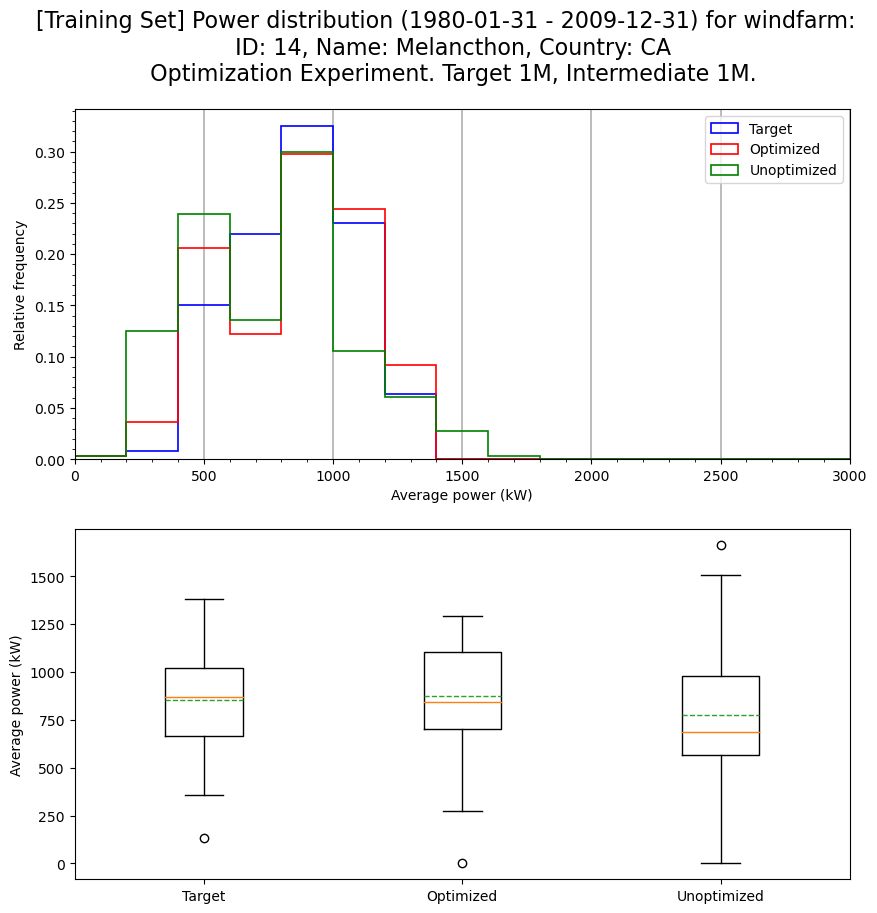

{'Pnom': 1450.186643173201, 'Drotor': 90.3946156361493, 'Vcutin': 3, 'Vcutoff': 25}


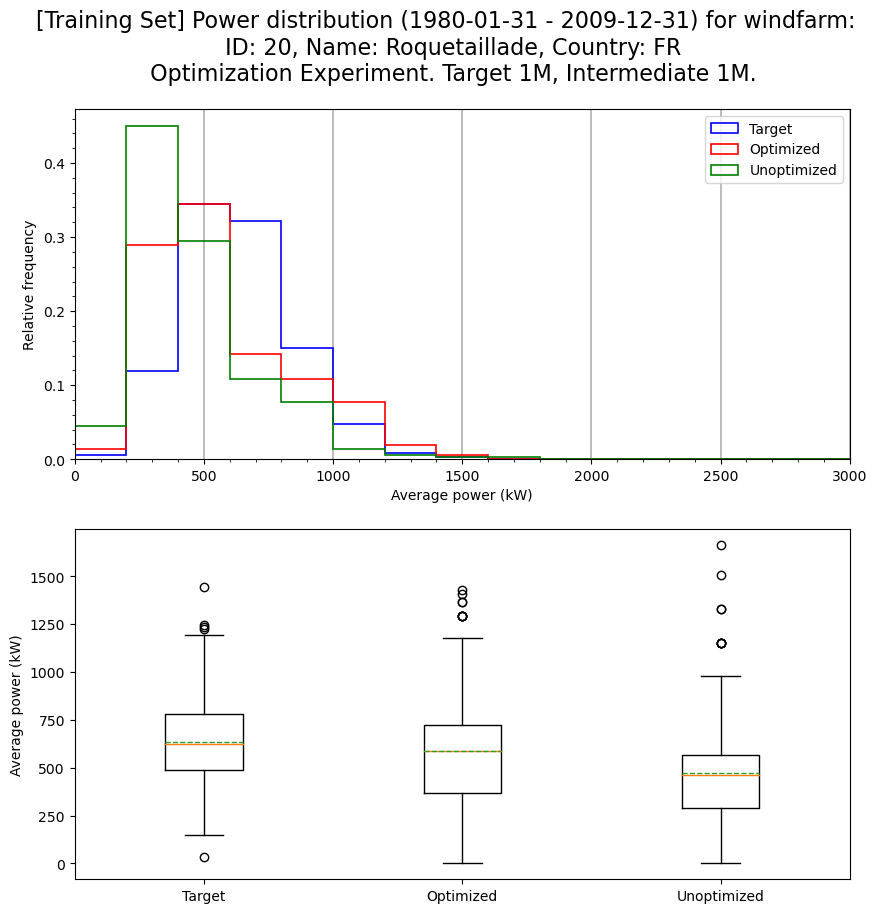

{'Pnom': 1364.4432086497545, 'Drotor': 91.06113832816482, 'Vcutin': 3, 'Vcutoff': 25}


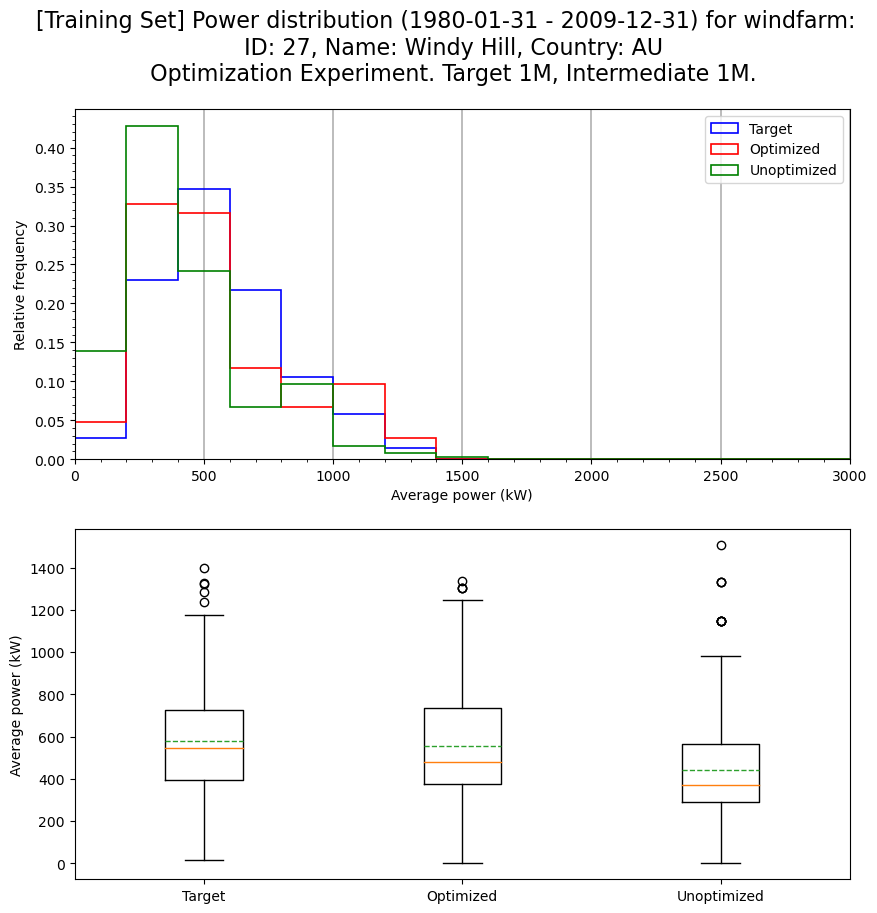

{'Pnom': 1304.988608494547, 'Drotor': 88.9378721216552, 'Vcutin': 3, 'Vcutoff': 25}


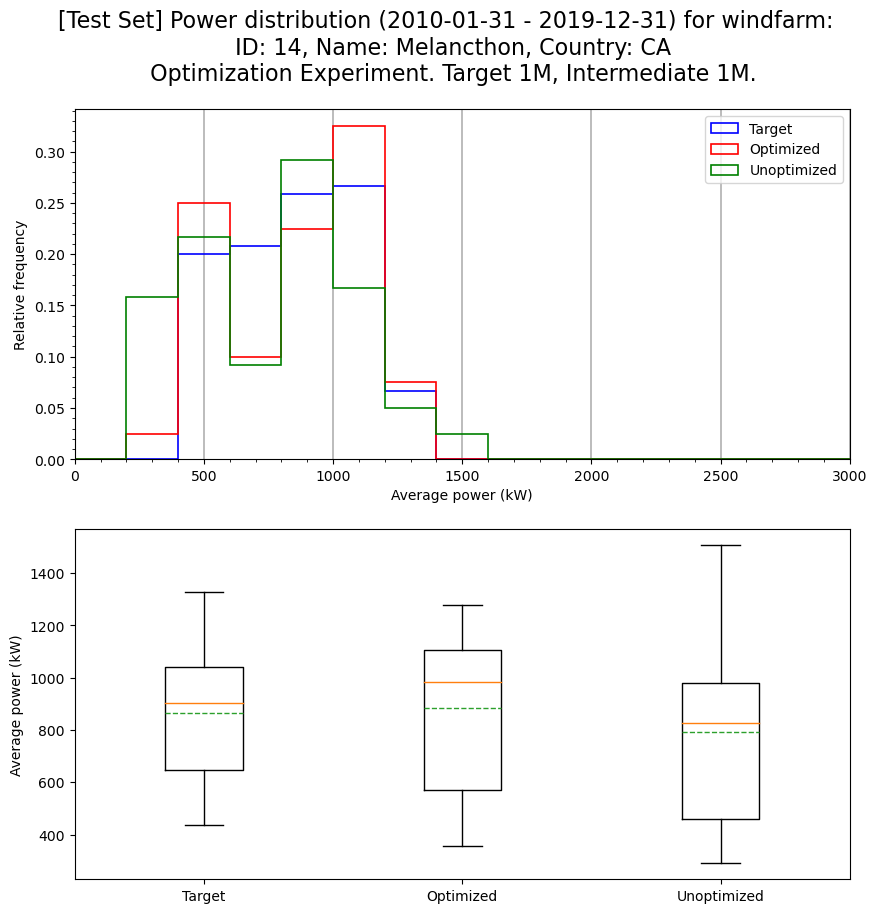

{'Pnom': 1450.186643173201, 'Drotor': 90.3946156361493, 'Vcutin': 3, 'Vcutoff': 25}


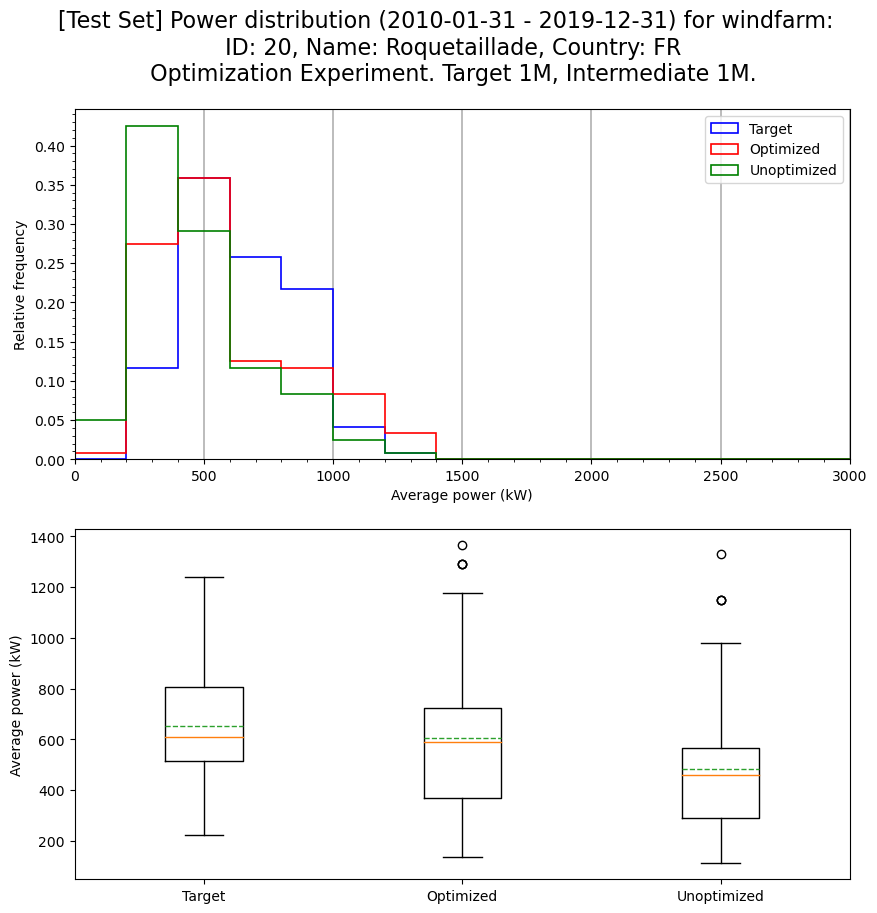

{'Pnom': 1364.4432086497545, 'Drotor': 91.06113832816482, 'Vcutin': 3, 'Vcutoff': 25}


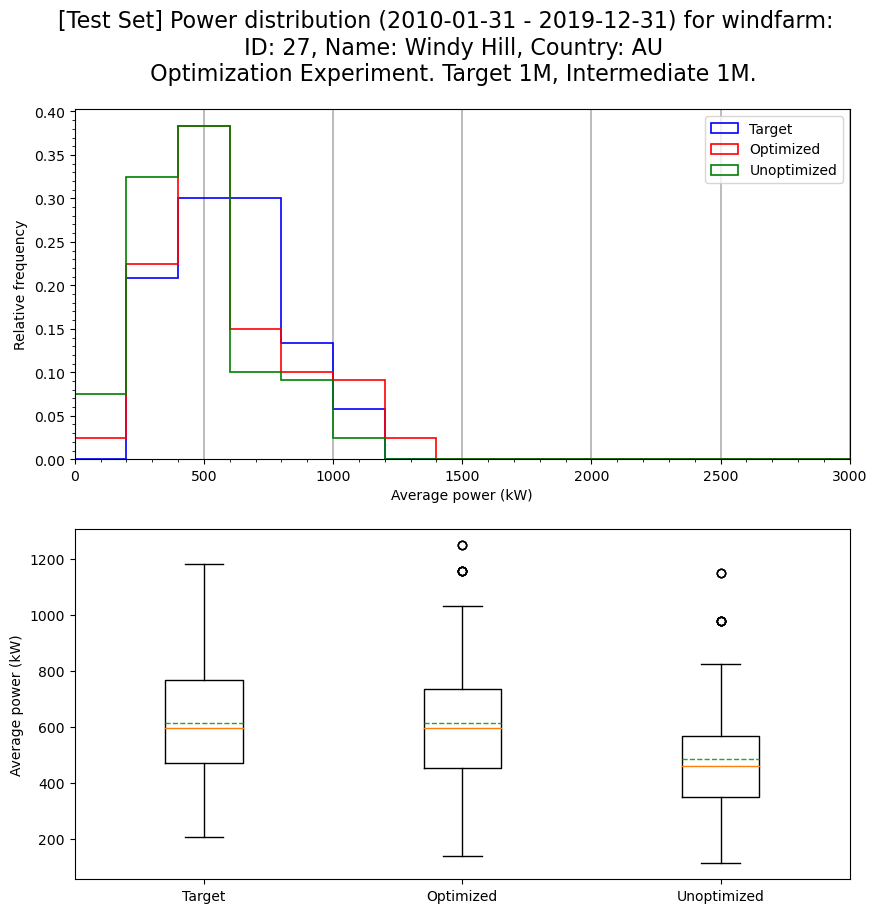

In [49]:
def plot_hist_and_boxplot(resminimize, averaged_wind_intermediate, power_da_target_tres, wind_farm_id, training_set: bool):
    assert isinstance(resminimize, dict)
    assert all([key in resminimize for key in ["Pnom", "Drotor", "Vcutin", "Vcutoff"]])
    optimized_conversion_function = pc.power_curve_from_parameters(**resminimize)

    print(resminimize)

    power_da_optimized = optimized_conversion_function(averaged_wind_intermediate)
    power_da_optimized_target_tres = power_da_optimized.resample(time=target_time_resolution).mean()

    power_da_unoptimized = power_conversion_functions[0](averaged_wind_intermediate)
    power_da_unoptimized_target_tres = power_da_unoptimized.resample(time=target_time_resolution).mean()


    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    labels_histogram = ["Target", "Optimized", "Unoptimized"]

    colors = ["blue", "red", "green"]

    bins = np.arange(0, 3200, 200)

    # plot the histograms
    for color, label, power_da_resampled in zip(
        colors, labels_histogram, (power_da_target_tres, power_da_optimized_target_tres, power_da_unoptimized_target_tres)):
        weights = np.ones_like(power_da_resampled) / len(power_da_resampled)
        n, bins, patches = axs[0].hist(power_da_resampled, bins=bins, weights=weights,
                                        edgecolor=color, linewidth=1.2,
                                        density=False, facecolor="none",
                                        histtype="step", label=label)
    
    axs[0].set_xlim(0, 3000)
    axs[0].set_ylim(0, axs[0].get_ylim()[1] / sum(n))

    axs[0].set_axisbelow(True)
    axs[0].grid(axis="x", linestyle="-", linewidth=1.2)
    axs[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    axs[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    axs[0].set_xlabel('Average power (kW)')
    axs[0].set_ylabel('Relative frequency')

    # use legend
    axs[0].legend(loc="upper right")

    # plot the boxplots
    axs[1].boxplot([power_da_target_tres, power_da_optimized_target_tres, power_da_unoptimized_target_tres], labels=labels_histogram,
                    showmeans=True, meanline=True)
    axs[1].set_ylabel('Average power (kW)')

    test_or_training = "Training Set" if training_set else "Test Set"

    start_date = power_da_optimized.time[0].dt.strftime("%Y-%m-%d").values
    end_date = power_da_optimized.time[-1].dt.strftime("%Y-%m-%d").values

    # set the title of the figure
    fig.suptitle("[{}] Power distribution ({} - {}) for windfarm: \n ID: {}, Name: {}, Country: {}\n Optimization Experiment. Target {}, Intermediate {}.".format(
        test_or_training, start_date, end_date,
        wind_farm_id, df[df["ID"] == wind_farm_id]["Name"].values[0], df[df["ID"] == wind_farm_id]["ISO code"].values[0],
        target_time_resolution, intermediate_time_resolution
    ), fontsize=16)
    plt.show()

optim_result_kwargs_collection = {
    wind_farm_id: {
        key: value for key, value
        in zip(free_parameters, optim_results)
    } for wind_farm_id, optim_results in optim_result_dict.items()
}

for wind_farm_id in optim_result_kwargs_collection:
    for key in ["Pnom", "Drotor", "Vcutin", "Vcutoff"]:
        if key not in optim_result_kwargs_collection[wind_farm_id]:
            optim_result_kwargs_collection[wind_farm_id][key] = starting_point[key]

for wind_farm_id, power_da_list in power_da_list_collection_training.items():
    averaged_wind_intermediate = wind_farm_ds_dict[wind_farm_id].sel(**training_set_selection).resample(time=intermediate_time_resolution).mean()
    power_da_target_tres = power_da_list[0].resample(time=target_time_resolution).mean()
    plot_hist_and_boxplot(optim_result_kwargs_collection[wind_farm_id], averaged_wind_intermediate, power_da_target_tres, wind_farm_id, training_set=True)

for wind_farm_id, power_da_list in power_da_list_collection_test.items():
    averaged_wind_intermediate = wind_farm_ds_dict[wind_farm_id].sel(**test_set_selection).resample(time=intermediate_time_resolution).mean()
    power_da_target_tres = power_da_list[0].resample(time=target_time_resolution).mean()
    plot_hist_and_boxplot(optim_result_kwargs_collection[wind_farm_id], averaged_wind_intermediate, power_da_target_tres, wind_farm_id, training_set=False)


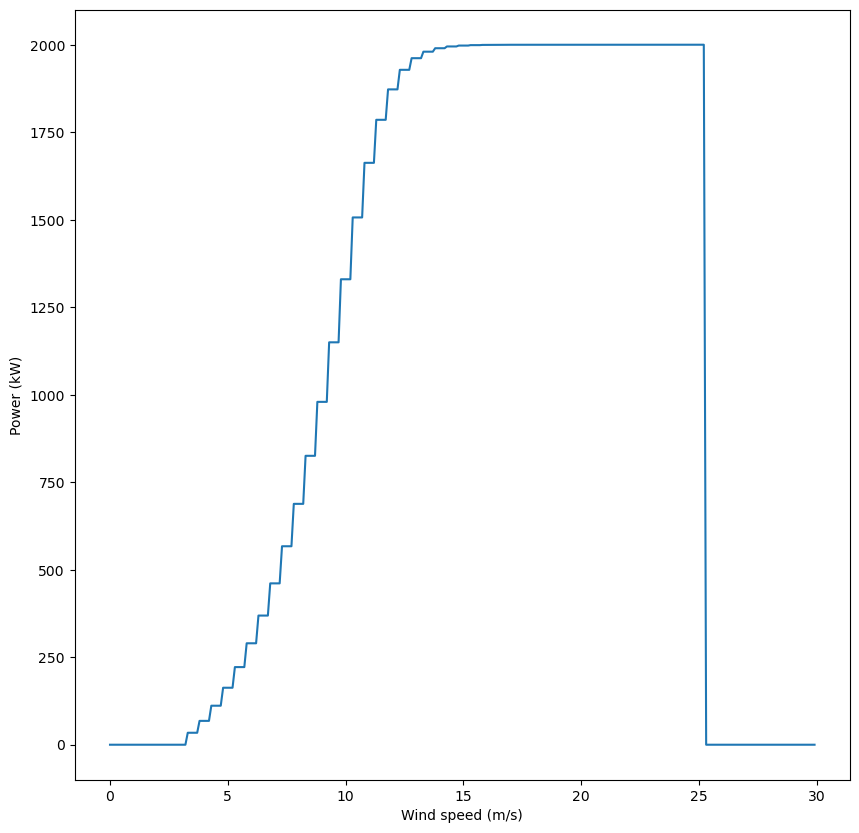

In [50]:
# plot the power curve for wind going from 0 to 30 m/s

wind_speeds = np.arange(0, 30, 0.1)
wind_speeds_da = xr.DataArray(wind_speeds, dims="time", coords={"time": wind_speeds})
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
power_conversion_function = pc.power_curve_from_parameters(
    Pnom=power_conversion_function_parameters[0]["Pnom"],
    Drotor=power_conversion_function_parameters[0]["Drotor"],
    Vcutin=3,
    Vcutoff=25
)
result = power_conversion_function(wind_speeds_da)
result = result.rename(time="wind_speed")
ax.plot(wind_speeds, result, label="Wind power curve")
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")
plt.show()